<a href="https://colab.research.google.com/github/vvmnnnkv/private-ai/blob/master/Section%201%20-%20Differential%20Privacy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project: Generate Parallel Databases


In [0]:
import Foundation
import TensorFlow

In [0]:
typealias Database = Tensor<Float>
typealias Query = (_ db: Database) -> Float

/// Return vector of 0 and 1 from uniform distibution
func createRandomBinaryVector(of shape: TensorShape, balance: Float? = 0.5) -> Database {
  return Tensor<Float>(Tensor(randomUniform: shape) .> (balance ?? 0.5))
}


In [0]:
/// Create parallel DB from original DB
func createParallelDb<T>(from tensor: Tensor<T>, dropping index: Int) -> Tensor<T> {
  var top = tensor.slice(lowerBounds: [0], upperBounds: [index])
  var bottom = tensor.slice(lowerBounds: [index + 1], upperBounds: [tensor.shape[0]])
  return top.concatenated(with: bottom)
}

In [0]:
/// Create all possible parallel DBs
func createParallelDbs<T>(from tensor: Tensor<T>) -> Array<Tensor<T>> {
  var result = Array<Tensor<T>>()
  for i in 0 ..< tensor.shape[0] {
    let pdb = createParallelDb(from: tensor, dropping: i)
    result.append(pdb)
  }
  return result
}

In [0]:
/// Create DB and parallal DBs for given number of entries
func createDbAndParallels(entries: Int, balance: Float? = 0.5) -> (db: Database, pdbs: Array<Database>) {
  let db = createRandomBinaryVector(of: [entries], balance: balance)
  let pdbs = createParallelDbs(from: db)
  return (db: db, pdbs: pdbs)
}

In [0]:
var (db, dbs) = createDbAndParallels(entries: 1000)

In [7]:
print(db.shape)
print(dbs.count)
print(dbs[0].shape)

[1000]
1000
[999]


# Project: Evaluating the Privacy of a Function

In [0]:
/// Calculate empirical sensitivity of a query
func sensitivity(of query: Query, with entries: Int, balance: Float? = 0.5) -> Float {
  var (db, pdbs) = createDbAndParallels(entries: entries, balance: balance)
  let dbQuery = query(db)
  var maxDifference:Float = 0
  for pdb in pdbs {
    let pdbQuery = query(pdb)
    let difference = abs(dbQuery - pdbQuery)
    if (maxDifference < difference) {
      maxDifference = difference
    }
  }
  return maxDifference
}

In [0]:
/// Sum query
let sumQuery:Query = { db in db.sum().scalar! }

In [10]:
sensitivity(of: sumQuery, with: 5000)

1.0


In [0]:
/// Mean query
let meanQuery:Query = { db in db.mean().scalar! }

In [12]:
sensitivity(of: meanQuery, with: 5000, balance: 0.5)

0.0001001358


In [13]:
for _ in 0..<10 {
  print(sensitivity(of: meanQuery, with: 100, balance: 0.99))
}


0.01
0.01
0.0
0.01
0.0
0.01
0.0
0.01
0.0
0.0


# Project: Calculate L1 Sensitivity For Threshold

In [0]:
/// General threshold of sum func
func threshold(_ db: Database, _ threshold: Float) -> Int {
  let sum = db.sum()
  return sum > threshold ? 1 : 0
}

/// Threshold is set to 5
let threshold5Query: Query = { db in Float(threshold(db, 5)) }

In [15]:
for _ in 0..<10 {
  print(sensitivity(of: threshold5Query, with: 10))
}

1.0
0.0
0.0
0.0
0.0
0.0
0.0
1.0
0.0
0.0


# Project: Perform a Differencing Attack on Row Idx 10

In [17]:
var db = createRandomBinaryVector(of: [100])
var idx = 10
var pdb = createParallelDb(from: db, dropping: idx)

// actual value of row with idx 10
print("actual value of row with idx:", db[idx])

// sum
print("retriving value with sum query:", sumQuery(db) - sumQuery(pdb))

// mean
print("retriving value with mean query:", meanQuery(db) - meanQuery(pdb))

// threshold
let actualSum = db.sum().scalar!
let thresholdXQuery:Query = { db in Float(threshold(db, actualSum - 1)) }
print("retrieving value with threshold query:", thresholdXQuery(db) - thresholdXQuery(pdb))

actual value of row with idx: 0.0
retriving value with sum query: 0.0
retriving value with mean query: -0.0049494803
retrieving value with threshold query: 0.0


# Project: Local Differential Privacy


In [0]:
/// Adds random coin flips noise
func addRandomCoinFlipNoise(to db: Database) -> Database {
  // 1st flip (1 - answer honestly, 0 - flip 2nd time)
  let flip1 = Tensor<Float>(Tensor(randomUniform: db.shape) .> 0.5)
  // 2nd flip
  let flip2 = Tensor<Float>(Tensor(randomUniform: db.shape) .> 0.5)
  // replace real values with randoms
  return flip1 * db + (1 - flip1) * flip2
}

In [20]:
// skewed_mean (of data noised with coin flips) = orig_mean * 0.5 + noise_mean * 0.5
// hence, orig_mean = skewed_mean * 2 - noise_mean
let meanCoinFlipNormalizedQuery: Query = { db in db.mean().scalar! * 2 - 0.5 }

for i in [10, 100, 1000, 10000] {
  let db = createRandomBinaryVector(of: [i])
  let privateDb = addRandomCoinFlipNoise(to: db)
  print("mean query with \(i) entries: orig: \(meanQuery(db)), w/ noise: \(meanCoinFlipNormalizedQuery(privateDb))")

}

mean query with 10 entries: orig: 0.6, w/ noise: 0.5
mean query with 100 entries: orig: 0.55, w/ noise: 0.5
mean query with 1000 entries: orig: 0.515, w/ noise: 0.53999996
mean query with 10000 entries: orig: 0.4971, w/ noise: 0.48799998


# Project: Varying Amounts of Noise


In [0]:
/// Adds specific amount of random noise
func addRandomNoise(to db: Database, amount: Float) -> Database {
  // 1st flip (1 - answer honestly, 0 - flip 2nd time)
  let flip1 = Tensor<Float>(Tensor(randomUniform: db.shape) .> amount)
  // 2nd flip
  let flip2 = Tensor<Float>(Tensor(randomUniform: db.shape) .> 0.5)
  // replace real values with randoms
  return flip1 * db + (1 - flip1) * flip2
}

In [23]:
/// Return true mean value, taking noise into account
func normalizedMean(_ db: Database, _ noiseAmount: Float, _ noiseMean: Float = 0.5) -> Float {
  // skewed_mean (of noised data) = orig_mean * (1 - noise_amount) + noise_mean * noise_amount
  // hence, orig_mean = (skewed_mean - noise_mean * noise_amount) / (1 - noise_amount)
  return (db.mean().scalar! - noiseMean * noiseAmount) / (1 - noiseAmount)
}


for balance in [0.5, 0.7] {
  for numEntries in [100, 1000, 10000] {
    let db = createRandomBinaryVector(of: [numEntries], balance: Float(balance))
    for noiseAmount:Float in [0, 0.1, 0.2, 0.4, 0.8, 0.99] {
      let meanNormalizedQuery: Query = { db in normalizedMean(db, noiseAmount) }
      let privateDb = addRandomNoise(to: db, amount: noiseAmount)
      print("balance: \(balance); mean, entries: \(db.shape[0]), noise: \(noiseAmount) - orig: \(meanQuery(db)), w/ noise: \(meanNormalizedQuery(privateDb))")
    }
  }
}


balance: 0.5; mean, entries: 100, noise: 0.0 - orig: 0.52, w/ noise: 0.52
balance: 0.5; mean, entries: 100, noise: 0.1 - orig: 0.52, w/ noise: 0.4888889
balance: 0.5; mean, entries: 100, noise: 0.2 - orig: 0.52, w/ noise: 0.5
balance: 0.5; mean, entries: 100, noise: 0.4 - orig: 0.52, w/ noise: 0.5666667
balance: 0.5; mean, entries: 100, noise: 0.8 - orig: 0.52, w/ noise: 0.64999986
balance: 0.5; mean, entries: 100, noise: 0.99 - orig: 0.52, w/ noise: -0.5
balance: 0.5; mean, entries: 1000, noise: 0.0 - orig: 0.488, w/ noise: 0.488
balance: 0.5; mean, entries: 1000, noise: 0.1 - orig: 0.488, w/ noise: 0.48333335
balance: 0.5; mean, entries: 1000, noise: 0.2 - orig: 0.488, w/ noise: 0.46625
balance: 0.5; mean, entries: 1000, noise: 0.4 - orig: 0.488, w/ noise: 0.50166667
balance: 0.5; mean, entries: 1000, noise: 0.8 - orig: 0.488, w/ noise: 0.54999995
balance: 0.5; mean, entries: 1000, noise: 0.99 - orig: 0.488, w/ noise: 1.7000036
balance: 0.5; mean, entries: 10000, noise: 0.0 - orig: 0

# Project: Create a Differentially Private Query


In [0]:
/// Laplace distribution
/// https://en.wikipedia.org/wiki/Laplace_distribution
public struct LaplaceDistribution: RandomDistribution {
    public let location: Float
    public let scale: Float
    private let uniformDist = UniformFloatingPointDistribution<Float>(lowerBound: -0.5, upperBound: 0.5)

    public init(location: Float = 0, scale: Float = 1) {
      self.location = location
      self.scale = scale
    }

    public func next<G: RandomNumberGenerator>(using rng: inout G) -> Float {
      let u = uniformDist.next(using: &rng)
      let s = self.scale * log(1 - 2 * abs(u))
      return u > 0 ? self.location - s : self.location + s
    }
}


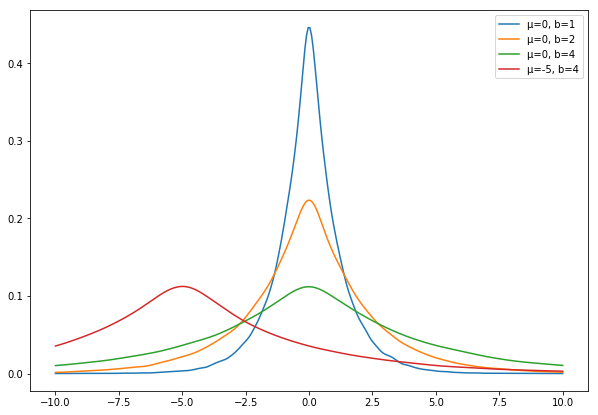

None


In [32]:
// let's draw LaplaceDistribution density plot 
// try to reproduce picture in https://en.wikipedia.org/wiki/Laplace_distribution
import Python
let plt = Python.import("matplotlib.pyplot")
let np = Python.import("numpy")
let stats = Python.import("scipy.stats")
%include "EnableIPythonDisplay.swift"
IPythonDisplay.shell.enable_matplotlib("inline")

let samples = 100000
let range = np.linspace(-10, 10, 300)
var legend: [String] = []
plt.figure(figsize: [10, 7])
for (l, s) in [(0, 1), (0, 2), (0, 4), (-5, 4)] {
  let ldist = LaplaceDistribution(location: Float(l), scale: Float(s))
  var nums: [Float] = []
  for _ in 0..<samples {
    nums.append(ldist.next(using: &PhiloxRandomNumberGenerator.global))
  }
  let density = stats.gaussian_kde(np.array(nums))
  plt.plot(range, density(range))
  legend.append("μ=\(l), b=\(s)")
}
plt.legend(legend)
plt.show()


In [0]:

/// Add DP with given sensitivity and epsilon
func makeDifferentiallyPrivate(value: Float, sensitivity: Float, epsilon: Float) -> Float {
  let scale = sensitivity / epsilon
  let dist = LaplaceDistribution(location: 0, scale: scale)
  return value + dist.next(using: &PhiloxRandomNumberGenerator.global)
}


In [28]:
for f in ["sum", "mean"] {
  let db = createRandomBinaryVector(of: [5000])
  for eps:Float in [0.001, 0.01, 0.1, 1, 10000] {
    var query: (_ db: Database) -> (orig: Float, dp: Float)
    switch (f) {
      case "sum":
        query = { db in 
          (
             orig: sumQuery(db),
             dp: makeDifferentiallyPrivate(value: sumQuery(db), sensitivity: 1, epsilon: eps)
          )
        }
        break
      case "mean":
        query = { db in 
          (
            orig: meanQuery(db), 
            dp: makeDifferentiallyPrivate(value: meanQuery(db), sensitivity: 1/Float(db.shape[0]), epsilon: eps)
          )
        }
        break
      default:
        fatalError("don't know \(f)")
        break
    }

    print("\(f) with eps=\(eps): ", query(db))
  }
}

sum with eps=0.001:  (orig: 2520.0, dp: 2120.0703)
sum with eps=0.01:  (orig: 2520.0, dp: 2419.825)
sum with eps=0.1:  (orig: 2520.0, dp: 2536.0552)
sum with eps=1.0:  (orig: 2520.0, dp: 2520.4658)
sum with eps=10000.0:  (orig: 2520.0, dp: 2520.0002)
mean with eps=0.001:  (orig: 0.4964, dp: 0.61891127)
mean with eps=0.01:  (orig: 0.4964, dp: 0.549329)
mean with eps=0.1:  (orig: 0.4964, dp: 0.4950993)
mean with eps=1.0:  (orig: 0.4964, dp: 0.4963673)
mean with eps=10000.0:  (orig: 0.4964, dp: 0.4964)


# Lesson: Differential Privacy for Deep Learning
## An Example Scenario: A Health Neural Network

- 1) You'll ask each of the 10 hospitals to train a model on their own datasets (All of which have the same kinds of labels)
- 2) You'll then use each of the 10 partner models to predict on your local dataset, generating 10 labels for each of your datapoints
- 3) Then, for each local data point (now with 10 labels), you will perform a DP query to generate the final true label. This query is a "max" function, where "max" is the most frequent label across the 10 labels. We will need to add laplacian noise to make this Differentially Private to a certain epsilon/delta constraint.
- 4) Finally, we will retrain a new model on our local dataset which now has labels. This will be our final "DP" model.

So, let's walk through these steps. I will assume you're already familiar with how to train/predict a deep neural network, so we'll skip steps 1 and 2 and work with example data. We'll focus instead on step 3, namely how to perform the DP query for each example using toy data.

So, let's say we have 10,000 training examples, and we've got 10 labels for each example (from our 10 "teacher models" which were trained directly on private data). Each label is chosen from a set of 10 possible labels (categories) for each image.

In [0]:
/// Return max element index
extension Array where Array.Element: Comparable {
  func argmax() -> Int? {
    if let m = self.max() {
      return self.firstIndex(of: m) ?? nil
    }
    return nil
  }
}

In [34]:
// settings
let hospitals = 10
let trainingExamples = 10000
let categories = 10
let epsilon:Float = 0.1

// fake predictions from hospitals
var predictions = Tensor<UInt8>(Tensor<Float>(randomUniform: [trainingExamples, hospitals]) * Float(categories))
// our final dataset calculated from hospitals' predictions
var localDatasetDp:[UInt8] = []
// same dataset but w/o DP
var localDatasetRaw:[UInt8] = []


for i in 0..<trainingExamples {
  // count predictions frequency to select most frequent label
  var predCounts:[Int] = Array(repeating: 0, count: categories)
  for val in predictions[i].array {
    predCounts[Int(val.scalar!)] += 1
  }
  
  // save most frequent label w/o applying DP
  if let result = predCounts.argmax() {
    localDatasetRaw.append(UInt8(result))
  }
  
  // apply DP for each label frequency value and save most frequent label
  // NOTE: this is sensitity of count query 
  let result = predCounts
    .map { makeDifferentiallyPrivate(value: Float($0), sensitivity: 1, epsilon: epsilon) }
    .argmax()
  if let result = result {
    localDatasetDp.append(UInt8(result))
  }
}

// let's check how much DP affected true argmax 
print(Tensor<Float>(Tensor(localDatasetDp) .== Tensor(localDatasetRaw)).sum().scalar! / Float(trainingExamples))



0.1257
